# CLEANING DATASET

In [1]:
import pandas as pd
#importing dataset
df = pd.read_csv(r'E:\major_project\datasets\rockyou_balanced.csv', encoding='latin-1')

In [2]:
df

,password,strength
0,123456,0
1,12345,0
2,123456789,0
3,password,0
4,iloveyou,0
...,...,...
440450,aidasaharudin,4
440451,oliviermitchmoute,4
440452,kesho.com007,4
440453,ethanisasexysped,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440455 entries, 0 to 440454
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  440454 non-null  object
 1   strength  440455 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.7+ MB


In [4]:
df['strength'].value_counts()

strength
1    100000
2    100000
3    100000
4    100000
0     40455
Name: count, dtype: int64

In [6]:
#removing null values and converting to string
df = df.dropna(subset=['password'])
df['password'] = df['password'].astype(str)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14748\3239588307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['password'] = df['password'].astype(str)


In [9]:
#checking duplicates
df.duplicated().sum()

350

In [10]:
#dropping the duplicates
df = df.drop_duplicates(subset="password")

In [11]:
df.duplicated().sum()

0

In [13]:
#removing invisible control characters
df = df[~df["password"].str.contains(r'[\x00-\x1F\x7F-\x9F]', na=True, regex=True)]

In [15]:
#adding length column, and removing passwords with length >=50
df['password'] = df['password'].str.strip()
df['length'] = df['password'].str.len()
df = df[(df['length'] > 0) & (df['length'] <= 50)]

In [17]:
#checking number of data after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 439396 entries, 0 to 440454
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  439396 non-null  object
 1   strength  439396 non-null  int64 
 2   length    439396 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.4+ MB


In [18]:
#class distribution in strength after cleaning
df["strength"].value_counts()

strength
1    99970
2    99955
3    99932
4    99559
0    39980
Name: count, dtype: int64

In [19]:
df.sample(20)

,password,strength,length
367786,0849905610130725,4,16
423942,*catia_danny*,4,13
344103,iglesia ni cristo,4,17
161984,04334513,2,8
268077,brajac1808,3,10
203640,heatherd7323,2,12
185433,deathboi3,2,9
400487,yaoie8919180g,4,13
56489,ocket,1,5
271420,0810507577,3,10


The RockYou dataset contains duplicated entries, empty strings, and non-printable characters due to encoding inconsistencies. These artifacts can bias learning algorithms and were therefore removed during preprocessing.

# FEATURE ADDITION

In [20]:
import pandas as pd
import numpy as np
import re
import math

In [24]:
#functions :

#for entropy
def pass_entropy(x):
    if not x:
        return 0
    #counting the frequency of unique characters
    freq = pd.Series(list(x)).value_counts()
    prob = freq/len(x)
    #shanon entropy formula
    return -np.sum(prob*np.log2(prob))

# for sequential patterns ( such as abc, qwerty)
def has_sequence(x):
    x_lower=x.lower()
    sequence = [
        'abcdefghijklmnopqrstuvwxyz',
        '0123456789',
        'qwertyuiopasdfghjklzxcvbnm'
    ]
    for seq in sequence:
        for i in range(len(seq) - 2):
            if seq[i:i+3] in x_lower:
                return 1
    return 0

#for maximum repeated character in a password
def max_repeated(x):
    if not x:
        return 0
    return max((len(m.group(0)) for m in re.finditer(r'(.)\1*', x)))
    
#this is the reverse of seq_letters    
def has_desc_sequence(x):
    x = x.lower()
    seqs = [
        'zyxwvutsrqponmlkjihgfedcba',
        '9876543210'
    ]
    for seq in seqs:
        for i in range(len(seq)-2):
            if seq[i:i+3] in x:
                return 1
    return 0

#this feature is to detect the presence of sustitutes such as adams -> @d@ms
def leet_count(x):
    return sum(c in "@$!013457" for c in x)

def has_year(x):
    return int(bool(re.search(r'(19|20)\d{2}', x)))

#this feature is added to detect passwords such as adams123, where there is a transistion of 1 (adams->1213)
def transitions(x):
    def char_type(c):
        if c.islower(): return "l"
        if c.isupper(): return "u"
        if c.isdigit(): return "d"
        return "s"
    
    return sum(
        char_type(x[i]) != char_type(x[i+1])
        for i in range(len(x)-1)
    )





In [25]:
## adding features:

#adding lowercase feature
df["lowercase_count"]=df["password"].str.count(r'[a-z]')

#counting uppercase characters
df["uppercase_count"]=df["password"].str.count(r'[A-Z]')

#counting special characters
df["special_count"]=df["password"].str.count(r'[^a-zA-Z0-9]')

#counting digits
df["digit_count"]=df["password"].str.count(r'[0-9]')

#if there are special characters, value is 1 else 0
df["has_special"]=(df['special_count']>0).astype(int)

#if there are digits,value is 1 else 0
df["has_digit"]=(df['digit_count']>0).astype(int)

#unique_chars means the no. of unique values in a password
#for e.g. "a!122" has 4 unique values (a,!,1,2)

df["unique_chars"] = df['password'].apply(lambda x:len(set(x)))

#char_diversity combines lowercase,uppercase,digit and special chars
#if one of them is present, value of char_diversity increases

df["char_diversity"]=(
    (df['lowercase_count']>0).astype(int)+
    (df['uppercase_count']>0).astype(int)+
    (df['digit_count']>0).astype(int)+
    (df['special_count']>0).astype(int)
)

#entropy
df["entropy"] = df['password'].apply(pass_entropy)

#sequential patterns
df['seq_letters'] = df['password'].apply(has_sequence)

#maximum repeated character count in a password
df['max_repeat'] = df['password'].apply(max_repeated)

##normalization for password containing certain digits
df["digit_ratio"] = df["digit_count"] / df["length"]

#normalized value for passwords with special characters
df["special_ratio"] = df["special_count"] / df["length"]

#normalized value for characters containing unique no. of characters((explained in notebook 2)
df["unique_ratio"] = df["unique_chars"] / df["length"]

#normalization of entropy
df["entropy_norm"]=df["entropy"]/df["length"]

df["desc_seq"] = df["password"].apply(has_desc_sequence)

#if there are digits,value is 1 else 0
df["has_year"] = df["password"].apply(has_year)

df["leet_count"] = df["password"].apply(leet_count)

df["transitions"] = df["password"].apply(transitions)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 439396 entries, 0 to 440454
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   password         439396 non-null  object 
 1   strength         439396 non-null  int64  
 2   length           439396 non-null  int64  
 3   lowercase_count  439396 non-null  int64  
 4   uppercase_count  439396 non-null  int64  
 5   special_count    439396 non-null  int64  
 6   digit_count      439396 non-null  int64  
 7   has_special      439396 non-null  int32  
 8   has_digit        439396 non-null  int32  
 9   unique_chars     439396 non-null  int64  
 10  char_diversity   439396 non-null  int32  
 11  entropy          439396 non-null  float64
 12  seq_letters      439396 non-null  int64  
 13  max_repeat       439396 non-null  int64  
 14  digit_ratio      439396 non-null  float64
 15  special_ratio    439396 non-null  float64
 16  unique_ratio     439396 non-null  float64
 

In [27]:
df.sample(30)

,password,strength,length,lowercase_count,uppercase_count,special_count,digit_count,has_special,has_digit,unique_chars,...,seq_letters,max_repeat,digit_ratio,special_ratio,unique_ratio,entropy_norm,desc_seq,has_year,leet_count,transitions
335892,nisakusayang,3,12,12,0,0,0,0,0,8,...,0,1,0.000000,0.000000,0.666667,0.237949,0,0,0,0
80405,762335,1,6,0,0,0,6,0,1,5,...,0,2,1.000000,0.000000,0.833333,0.375272,0,0,4,0
124539,kaal01,1,6,4,0,0,2,0,1,5,...,0,2,0.333333,0.000000,0.833333,0.375272,0,0,2,1
45774,2025827,1,7,0,0,0,7,0,1,5,...,0,1,1.000000,0.000000,0.714286,0.304012,0,1,3,0
181607,5x8o02t6,2,8,3,0,0,5,0,1,8,...,0,1,0.625000,0.000000,1.000000,0.375000,0,0,2,6
322107,09103303190,3,11,0,0,0,11,0,1,4,...,0,2,1.000000,0.000000,0.363636,0.176024,0,0,9,0
354991,ROSAFARCIERT,4,12,0,12,0,0,0,0,9,...,1,1,0.000000,0.000000,0.750000,0.251838,0,0,0,0
384635,1509900536120,4,13,0,0,0,13,0,1,7,...,0,2,1.000000,0.000000,0.538462,0.201809,0,0,9,0
190928,rcoowwe,2,7,7,0,0,0,0,0,5,...,0,2,0.000000,0.000000,0.714286,0.319418,0,0,0,0
290455,faith&trust,3,11,10,0,1,0,1,0,9,...,0,1,0.000000,0.090909,0.818182,0.275197,0,0,0,2


# EDA


In [28]:
#importing libraries
import matplotlib.pyplot as plt
import seaborn as sns

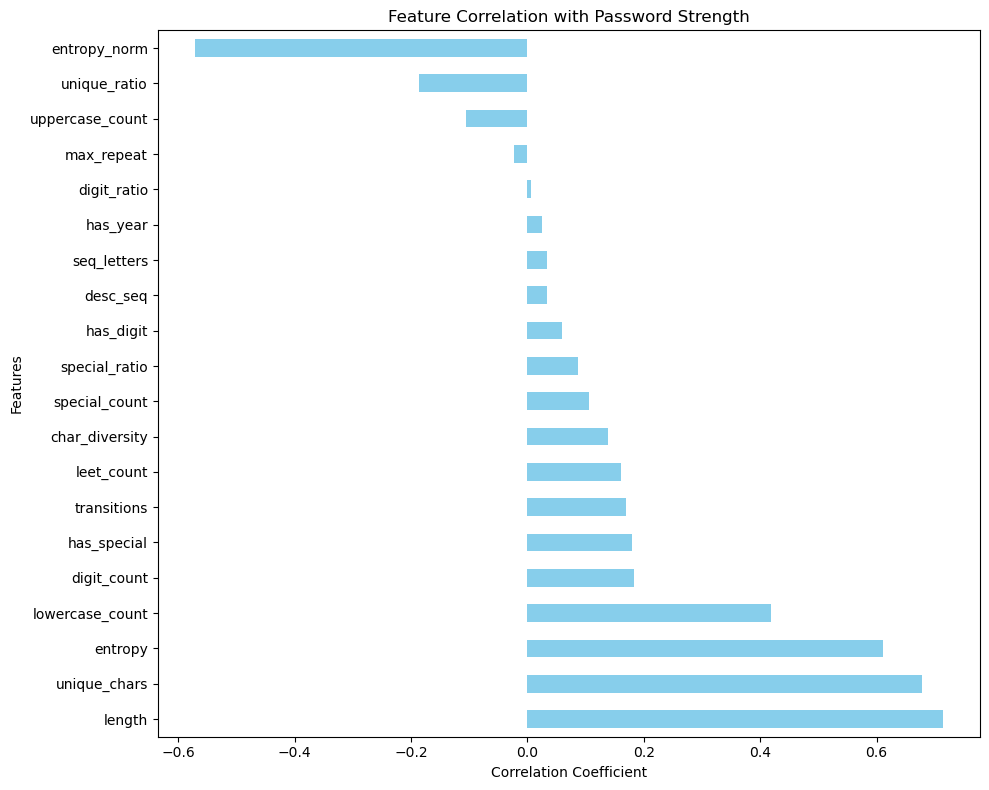

In [29]:
# Calculate correlation with the target 'strength'
correlations = df.drop(columns=['password']).corr()['strength'].sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
correlations.drop('strength').plot(kind='barh', color='skyblue')
plt.title('Feature Correlation with Password Strength')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('feature_correlation.png')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14748\3141049373.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='strength', y=feature, data=df, ax=axes[i], palette='viridis')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14748\3141049373.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='strength', y=feature, data=df, ax=axes[i], palette='viridis')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14748\3141049373.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='strength', y=feature, data=df, ax=axes[i], palette='viridis')
C:\Users\ASUS\Ap

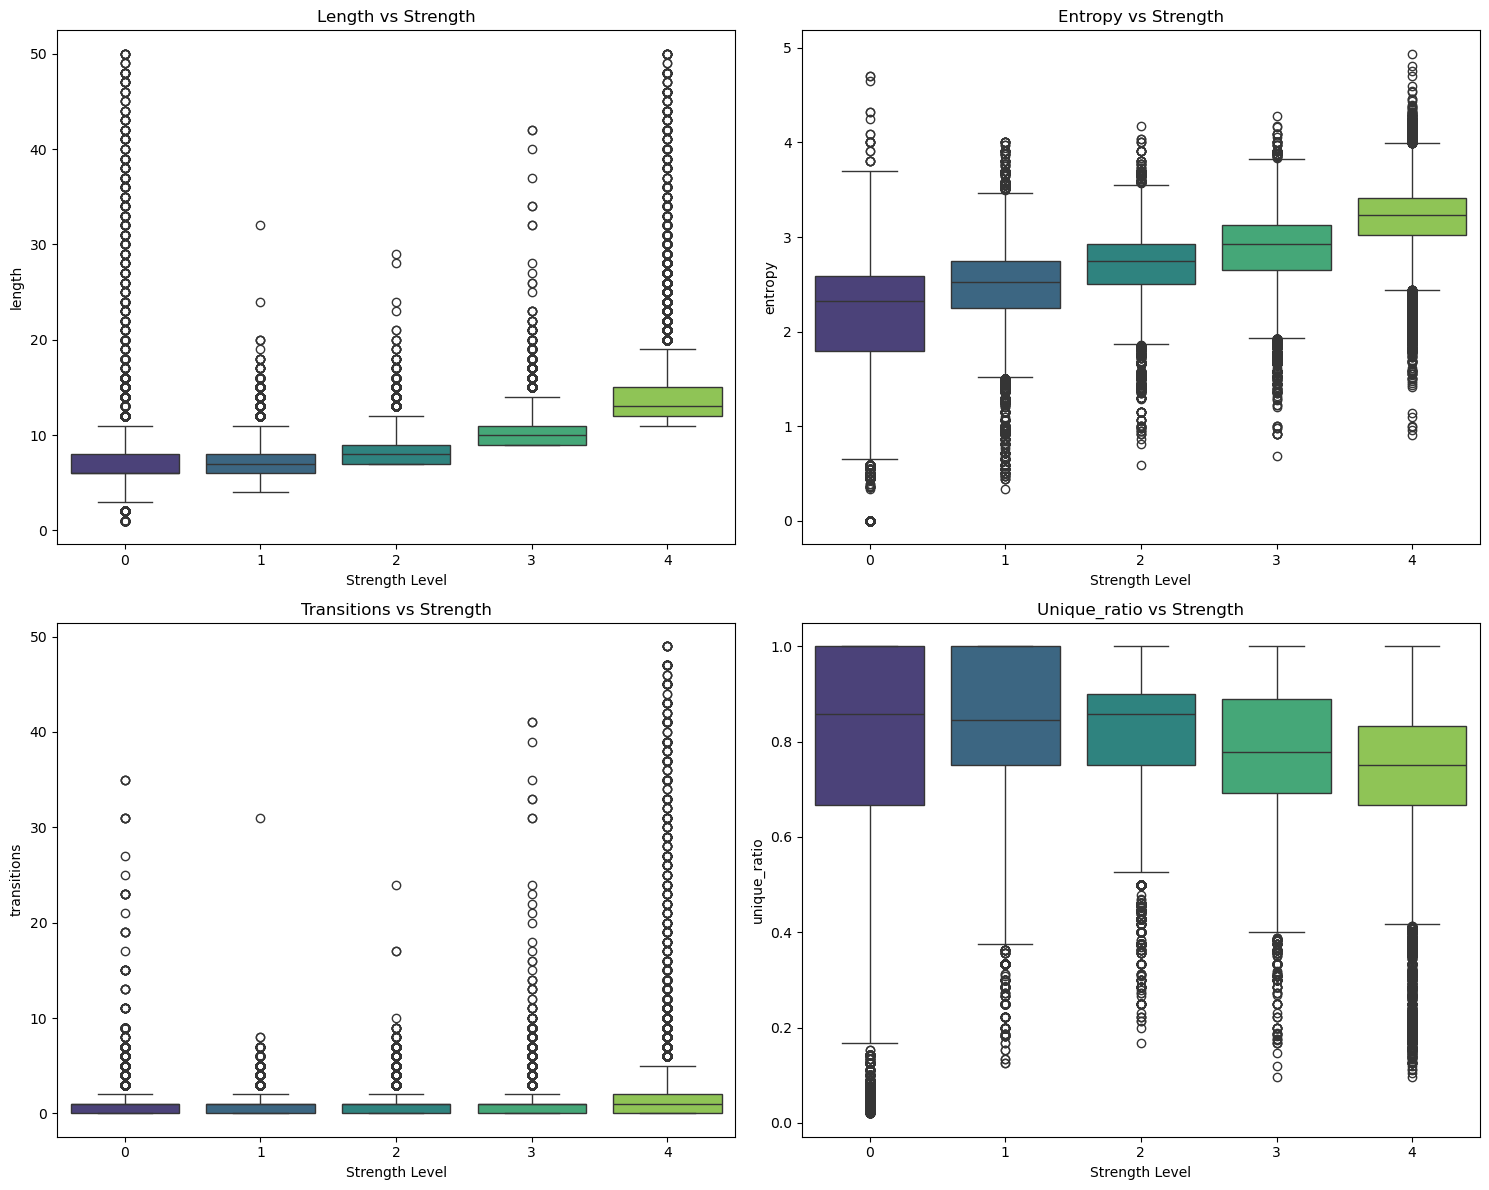

In [30]:
#identifying class separation through boxplot
features_to_plot = ['length', 'entropy', 'transitions', 'unique_ratio']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.boxplot(x='strength', y=feature, data=df, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{feature.capitalize()} vs Strength')
    axes[i].set_xlabel('Strength Level')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.savefig('feature_separation_boxplots.png')

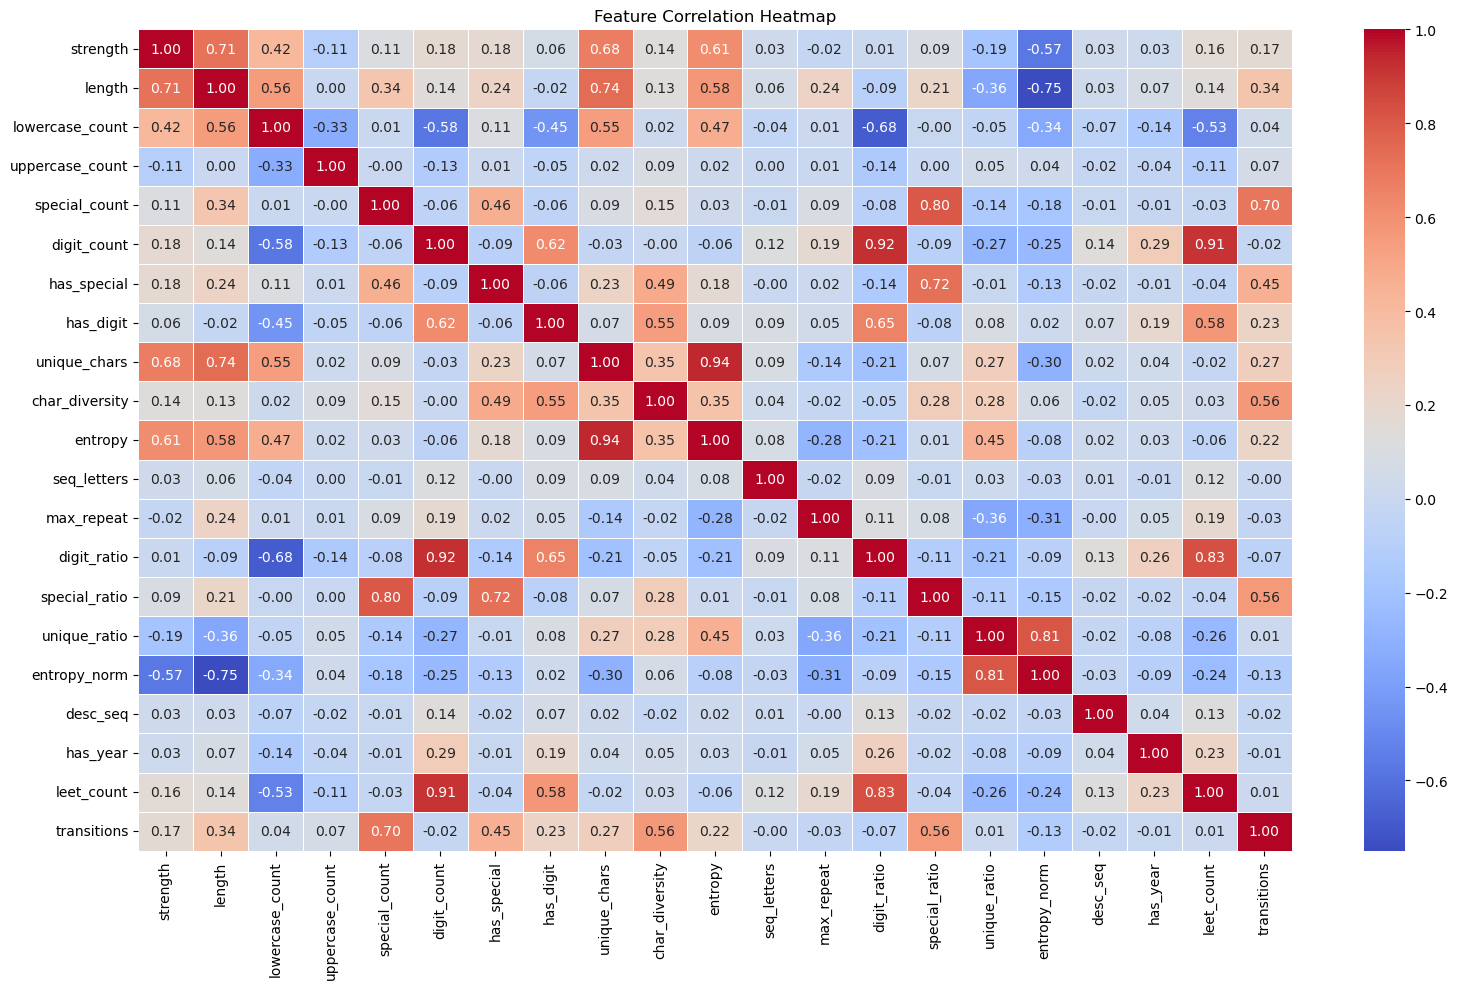

In [31]:
#heatmap for correlation
plt.figure(figsize=(16, 10))
# Using only numeric columns for the heatmap
numeric_df = df.drop(columns=['password']).select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14748\1746332802.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='strength', y='char_diversity', data=df, inner="quart", palette="muted")


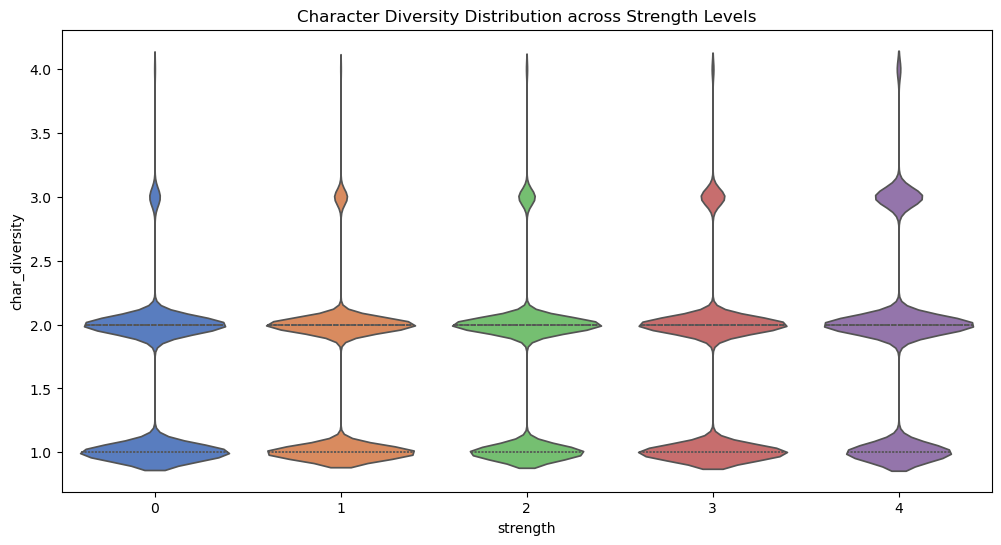

In [32]:
#violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='strength', y='char_diversity', data=df, inner="quart", palette="muted")
plt.title('Character Diversity Distribution across Strength Levels')
plt.savefig('char_diversity_violin.png')

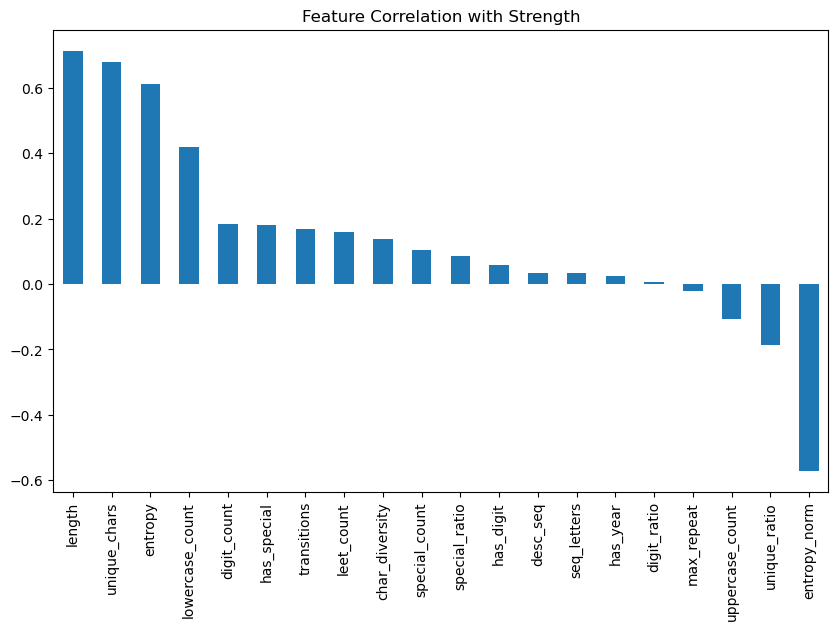

In [34]:
#checking the top 5 correlation features with strength

import matplotlib.pyplot as plt
import seaborn as sns

# Plot top correlations
plt.figure(figsize=(10,6))
df.select_dtypes(include=[float, int]).corr()['strength'].sort_values(ascending=False).drop('strength').plot(kind='bar')
plt.title("Feature Correlation with Strength")
plt.show()

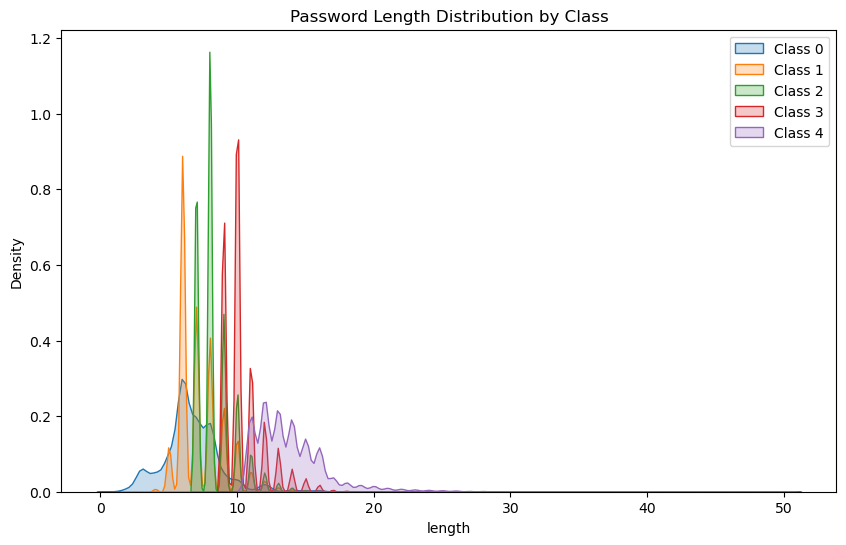

In [35]:
# length density plot
plt.figure(figsize=(10,6))
for i in range(5):
    sns.kdeplot(df[df['strength'] == i]['length'], label=f'Class {i}', fill=True)
plt.title("Password Length Distribution by Class")
plt.legend()
plt.show()

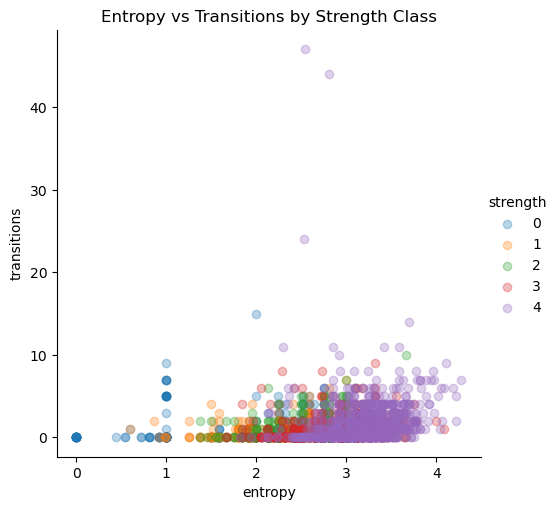

In [36]:
#class separation check
# Sample 5000 rows for a quick, readable plot
sns.lmplot(x='entropy', y='transitions', data=df.sample(5000), hue='strength', fit_reg=False, scatter_kws={'alpha':0.3})
plt.title("Entropy vs Transitions by Strength Class")
plt.show()

#  saving the dataset

In [ ]:

# Check class distribution
df["strength"].value_counts()



strength
1    99970
2    99955
3    99932
4    99559
0    39980
Name: count, dtype: int64

In [39]:
# Check no missing values
df.isna().sum().sum()


0

In [41]:
df.to_csv(r"E:\major_project\datasets\final_clean_df.csv",
          index=False)